In [62]:
from pathlib import Path 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from collections import OrderedDict
import sys
import os
import seaborn as sns
import researchpy as rp
import statsmodels.formula.api as smf
import scipy.stats as stats
import ipympl

#sys.path.append('/Users/alina/Desktop/MIT/code/ADHD/MTA/helper')
from helper import rr, prep, var_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
if Path('/Volumes/Samsung_T5/MIT/mta').exists():
    data_root =     '/Volumes/Samsung_T5/MIT/mta'
    data_derived = '/Volumes/Samsung_T5/MIT/mta/output/derived_data'
else: 
    data_root = '/Users/alina/Desktop/MIT/code/data'
    data_derived = '/Users/alina/Desktop/MIT/code/data/output/derived_data'

In [126]:
snap = pd.read_csv(Path(data_derived, 'snap_14_and_mediators.csv'))
ssrs = pd.read_csv(Path(data_derived, 'ssrs_14_and_mediators.csv'))
masc = pd.read_csv(Path(data_derived, 'masc_14_and_mediators.csv'))
pc = pd.read_csv(Path(data_derived, 'pc_14_and_mediators.csv'))
qsts =['snap', 'ssrs', 'masc', 'pc']
data_dict = dict(zip(['snap', 'ssrs', 'masc', 'pc'], [snap, ssrs, masc, pc]))

In [234]:
#remove subjects from the 'assessemnt' period (before baseline)
for key, df in data_dict.items():
    data_dict[key] = df[df['trtname'] != 'A'].copy()  #

In [235]:
interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group

# mediator variables
comorb_mediators  = ['cdorodd' , 'pso', 'psoi', 'pag', 'pagi', 'pga', 'pgai' ,'psa'] #ODD/CD or anx excluding specific phobia 
services_mediators =  ['demo61'] #reciept of public assistance 
prev_med_mediators = ['hi_24'] #medication intake prior to study 

#moderator variables 
accept_moderator = ['d2dresp'] # initail acceptance of treatment 
raters = ['Teacher', 'Parent']

med_mod_list = np.concatenate([[comorb_mediators[0]], ['anx'], services_mediators, prev_med_mediators, accept_moderator, ['sex']])
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [236]:
comorb = pd.read_csv(Path(data_derived, 'comorb.csv'), index_col= 0) # comorbid ODD/CD anxiety
prev_med = pd.read_csv(Path(data_derived, 'prev_med.csv'), index_col= 0) #'prevous stimulant medictaion exposure
assist = pd.read_csv(Path(data_derived, 'assist.csv'), index_col= 0) #reciept of public assistance 
accept = pd.read_csv(Path(data_derived, 'accept.csv'), index_col= 0) #initial acceptance of treatment arm
medi = {'comorb': comorb, 'prev_med': prev_med, 'assist': assist, 'accept': accept}

In [237]:

interaction_predictors = ['days_baseline', 'site', 'trtname'] #time, site, treatment group
#outcome variablles 
snap_vars = ['snainatx', 'snahypax', 'snaoddx'] #inattention_mean, hyperactie mean
ssrs_vars = ['sspintx', 'ssptossx']# social skills mean, internalizing mean 
masc_vars = ['masc_masctotalt']
pc_vars = ['pcrcpax', 'pcrcprx'] # power assertion, personal closeness
#wechsler_vars = ['w1readb','w2math','w3spell' ]

outcomes_dict  = {'snap' : snap_vars, 'ssrs' : ssrs_vars, 'masc': masc_vars, 'pc': pc_vars}#, 'wechsler': wechsler_vars}

### RR analysis, including each mediator as main effect and in interaction : if significant plot 

In [238]:
gen_interact_formula = ' days_baseline + C(site) + C(trtname)' # reapeat with log days 


In [239]:
med_mod_list

array(['cdorodd', 'anx', 'demo61', 'hi_24', 'd2dresp', 'sex'], dtype='<U7')

In [240]:
#include mediators and moderator as main effect and in interaction 
gen_med_formulas = [ gen_interact_formula +' * '+  str(med) for med in med_mod_list]
gen_med_formulas

formulas =  [[[' ~ '.join((var, gen_med_form)) for var in values] for gen_med_form in gen_med_formulas] for values in outcomes_dict.values()] 
formulas_dict = dict(zip(outcomes_dict.keys(), formulas))
formulas_dict

{'snap': [['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site

In [241]:
groups = 'src_subject_id'
alpha = 0.05
raters = ['Teacher', 'Parent']

In [242]:
formulas_dict['snap']

[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
  'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
  'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * sex',
 

## SNAP

In [243]:
formulas_snap = formulas_dict['snap']
formulas_snap

[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
  'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
  'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
  'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
 ['snainatx ~  days_baseline + C(site) + C(trtname) * sex',
 

In [257]:
snap.trtname.unique()

array(['C', 'M', 'A', 'P'], dtype=object)

In [245]:
interaction_predictors

['days_baseline', 'site', 'trtname']

In [246]:
formulas

[[['snainatx ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snahypax ~  days_baseline + C(site) + C(trtname) * cdorodd',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * cdorodd'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * anx',
   'snahypax ~  days_baseline + C(site) + C(trtname) * anx',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * anx'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * demo61',
   'snahypax ~  days_baseline + C(site) + C(trtname) * demo61',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * demo61'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snahypax ~  days_baseline + C(site) + C(trtname) * hi_24',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * hi_24'],
  ['snainatx ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snahypax ~  days_baseline + C(site) + C(trtname) * d2dresp',
   'snaoddx ~  days_baseline + C(site) + C(trtname) * d2dresp'],
  ['snainatx ~  days_baseline + C(site) + C(tr

In [249]:

cols = np.concatenate([['src_subject_id'], interaction_predictors])
print(cols)
results = {}
for i, qst in enumerate(qsts) :
    results_ = {}
    for j, med in enumerate(med_mod_list):

        for k, var in enumerate(outcomes_dict[qst]):
            cols_total = np.concatenate([cols, [med, var]])
            print(cols_total)
            formula = formulas[i][j][k]
            data = data_dict[qst][cols_total].dropna()
            groups = data['src_subject_id']
            result = smf.mixedlm(formula, data, groups = groups).fit()
            results_[str(med) + '_' + str(var) ] = result
    results[qst] = results_
            
        

['src_subject_id' 'days_baseline' 'site' 'trtname']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snainatx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snahypax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'cdorodd' 'snaoddx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snainatx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snahypax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'anx' 'snaoddx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snainatx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snahypax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'demo61' 'snaoddx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snainatx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snahypax']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'hi_24' 'snaoddx']
['src_subject_id' 'days_baseline' 'site' 'trtname' 'd2dresp' 'snainatx']
['src_subject_id' 'days_

In [285]:
results['pc'].keys()

dict_keys(['cdorodd_pcrcpax', 'cdorodd_pcrcprx', 'anx_pcrcpax', 'anx_pcrcprx', 'demo61_pcrcpax', 'demo61_pcrcprx', 'hi_24_pcrcpax', 'hi_24_pcrcprx', 'd2dresp_pcrcpax', 'd2dresp_pcrcprx', 'sex_pcrcpax', 'sex_pcrcprx'])

In [294]:
result = results['ssrs']['demo61_ssptossx']

In [295]:
data = data_dict['ssrs']

In [296]:
data['demo61'].unique()

array([nan,  2.,  1.])

In [297]:
data['predicted'] = result.predict(data)

/Users/alina/opt/anaconda3/envs/abcd/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


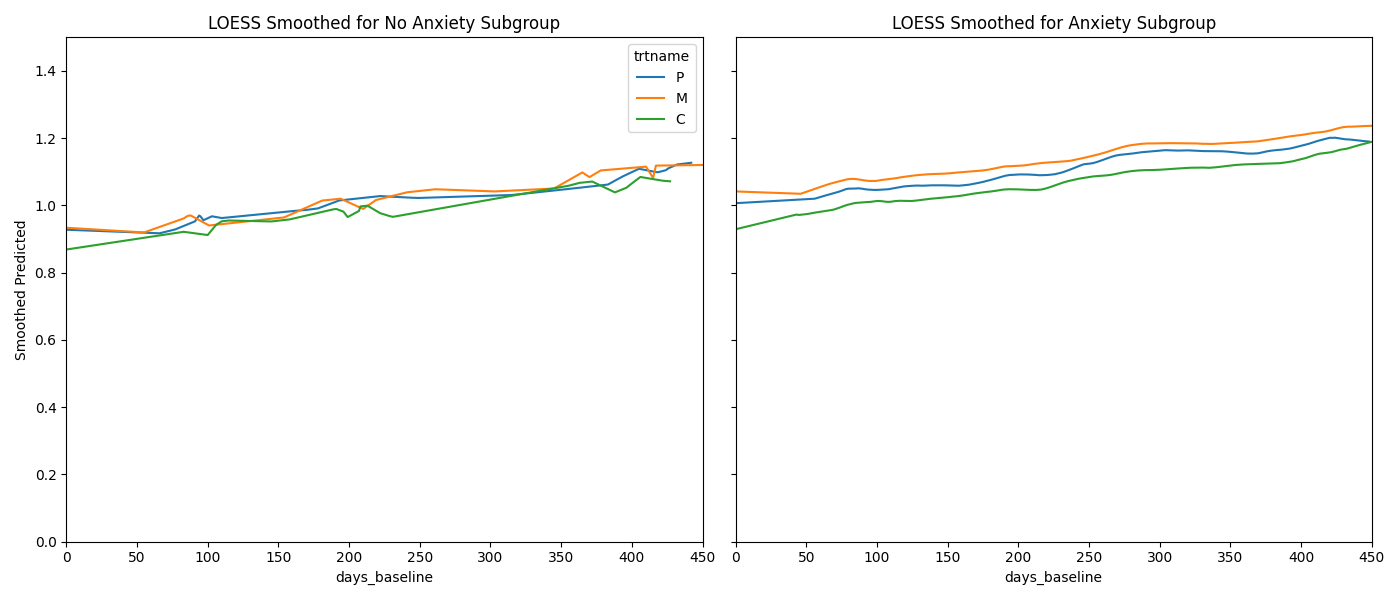

In [298]:
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

# Apply LOESS smoothing for "No Anxiety" and "Anxiety" subgroups, and filter for days_baseline >= 0
no_mod = data[(data['demo61'] == 1) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]
yes_mod = data[(data['demo61'] == 2) & (data['days_baseline'] >= 0) & (data['days_baseline'] <= 450)]

# Create subplots (1 row, 2 columns) with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for "No Anxiety" subgroup
for trt in no_mod['trtname'].unique():
    subset = no_mod[no_mod['trtname'] == trt]
    smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
    axes[0].plot(smoothed[:, 0], smoothed[:, 1], label=trt)

axes[0].set_title('LOESS Smoothed for No Anxiety Subgroup')
axes[0].set_xlabel('days_baseline')
axes[0].set_ylabel('Smoothed Predicted')
axes[0].legend(title='trtname')
axes[0].set_xlim(0, 450)  # Set x-axis from 0 to 450
axes[0].set_ylim(0, 3)    # Set y-axis from 0 to 3

# Plot for "Anxiety" subgroup
for trt in yes_mod['trtname'].unique():
    subset = yes_mod[yes_mod['trtname'] == trt]
    smoothed = lowess(subset['predicted'], subset['days_baseline'], frac=0.1)
    axes[1].plot(smoothed[:, 0], smoothed[:, 1], label=trt)

axes[1].set_title('LOESS Smoothed for Anxiety Subgroup')
axes[1].set_xlabel('days_baseline')
axes[1].set_xlim(0, 450)  # Set x-axis from 0 to 450
axes[1].set_ylim(0, 1.5)    # Ensure y-axis is from 0 to 3

# Show the plot
plt.tight_layout()
plt.show()

In [273]:
data = snap[:100]
groups = data['src_subject_id']
data.shape
formula

'pcrcprx ~  days_baseline + C(site) + C(trtname) * sex'

In [118]:
data = snap[['src_subject_id', 'trtname', 'days_baseline', 'site','snahypax' ,'cdorodd']].dropna()
groups = data['src_subject_id']
data.shape

(5048, 6)

In [119]:
result_test = smf.mixedlm(formula, data=data , groups= groups).fit()

In [61]:
result_snap = [[[ smf.mixedlm(formulas_dict['snap'][i][j], data_dict['snap']['14'][data_dict['snap']['14']['version_form'] == rater], groups = groups).fit() for rater in raters] for i in range(len(snap_vars))] for j in range(len(med_mod_list))]

KeyError: '14'

In [ ]:
result_ssrs = [[ smf.mixedlm(formulas_dict['ssrs'][i], data['ssrs']['14'][data['ssrs']['14']['version_form'] == rater], groups = groups).fit() for rater in raters] for i in range(len(ssrs_vars))]